In [1]:
import torch
import json
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
# Synthesis vector parsing
lines = []
with open('project_synth_vec_data.csv') as f:
    lines = f.readlines()

count = 0
synth_vec = {}
for line in lines:
    count += 1
    line = line.replace("\"","")
    line = line.split(",")
    synth_vec[int(line[0])] = []
    synth_vec[int(line[0])] = line[1:len(line)-1]

for key in synth_vec:
    print(key)
    for j in range(len(synth_vec[key])):
        synth_vec[key][j] = int(synth_vec[key][j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
# Train test data parsing
X_train = []
Y_train = []
train = []

X_test = []
Y_test = []
test = []

f = open('train_datapoints.json')
data_x = json.load(f)
print (len(data_x))
ohe_dict = {}
designs = list(data_x.keys())
for i in range(len(data_x)):
    ohe_dict[designs[i]] = np.zeros(len(data_x))
    ohe_dict[designs[i]][i] = 1

    
print ("data_x", len(data_x))
for i in range(len(data_x)):
    for j in data_x[designs[i]]:
        ll = int(j)
        dummy_x = [data_x[designs[i]][j][0], data_x[designs[i]][j][1] ,data_x[designs[i]][j][2], data_x[designs[i]][j][3]]
        for k in range(len(synth_vec[ll-1])):
            dummy_x.extend([synth_vec[ll-1][k]])
        dummy_x.extend(ohe_dict[designs[i]])
        dummy_x.extend([data_x[designs[i]][j][4]]) # delay should be the last element    
        train.append(dummy_x)

print (train[1600])        
f = open('test_datapoints.json')
data_t = json.load(f)
print ("data_t", len(data_t))
for i in range(len(data_t)):
    for j in data_t[designs[i]]:
        ll = int(j)
        dummy_x = [data_t[designs[i]][j][0], data_t[designs[i]][j][1], data_t[designs[i]][j][2], data_t[designs[i]][j][3]]
        for k in range(len(synth_vec[ll-1])):
            dummy_x.extend([synth_vec[ll-1][k]])
        dummy_x.extend(ohe_dict[designs[i]])    
        dummy_x.extend([data_t[designs[i]][j][4]]) # delay should be the last element
        test.append(dummy_x)

print (test[1])

42
data_x 42
[425, 472, 10, 326.91, 2, 4, 4, 5, 3, 3, 2, 4, 4, 5, 4, 6, 5, 6, 2, 3, 0, 1, 4, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 254.23]
data_t 42
[6633, 7035, 20, 5001.6, 1, 6, 4, 4, 1, 1, 5, 4, 3, 0, 0, 2, 1, 2, 3, 2, 3, 6, 0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2847.77]


In [4]:
#Scaling the train data
train = np.array(train)
print (train[0])

#Standardization
#print(np.mean(train, axis = 0))
#print(np.std(train, axis = 0))
#train = (train - np.mean(train, axis = 0))/np.std(train, axis = 0)

#Min-max scaling
print("Min elements", np.amin(train, axis = 0))
print("Max elements", np.amax(train, axis = 0))
train = (train - np.amin(train, axis=0))/(np.amax(train, axis=0) - np.amin(train, axis=0))
train

[6.67100e+03 7.23400e+03 2.20000e+01 4.75821e+03 5.00000e+00 3.00000e+00
 0.00000e+00 2.00000e+00 2.00000e+00 6.00000e+00 0.00000e+00 4.00000e+00
 3.00000e+00 0.00000e+00 6.00000e+00 4.00000e+00 3.00000e+00 4.00000e+00
 2.00000e+00 0.00000e+00 4.00000e+00 4.00000e+00 3.00000e+00 1.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.36965e+03]
Min elements [395.   452.     7.   259.62   0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     

array([[0.05951297, 0.04445377, 0.01849568, ..., 0.        , 0.        ,
        0.01689339],
       [0.05968366, 0.04396217, 0.01479655, ..., 0.        , 0.        ,
        0.03117058],
       [0.05914315, 0.04155005, 0.01726264, ..., 0.        , 0.        ,
        0.01391002],
       ...,
       [0.0783834 , 0.06785394, 0.01972873, ..., 0.        , 1.        ,
        0.0119946 ],
       [0.07848771, 0.0675262 , 0.02096178, ..., 0.        , 1.        ,
        0.01402112],
       [0.07889546, 0.06839797, 0.01972873, ..., 0.        , 1.        ,
        0.01429445]])

In [5]:
# Scaling the test data
test = np.array(test, dtype=np.float32)
test = np.array(test)
#Standardization
#test = (test - np.mean(test, axis = 0))/np.std(test, axis = 0)
#Min-max scaling
test = (test - np.amin(test, axis=0))/(np.amax(test, axis=0) - np.amin(test, axis=0))
test

array([[0.05938961, 0.04161639, 0.01602959, ..., 0.        , 0.        ,
        0.01714667],
       [0.05879581, 0.04314438, 0.01602959, ..., 0.        , 0.        ,
        0.01320747],
       [0.06254712, 0.04734143, 0.02096178, ..., 0.        , 0.        ,
        0.03819021],
       ...,
       [0.07789172, 0.06777582, 0.02096178, ..., 0.        , 1.        ,
        0.01231765],
       [0.07791057, 0.06759876, 0.01972873, ..., 0.        , 1.        ,
        0.01203229],
       [0.07779747, 0.06780206, 0.02096178, ..., 0.        , 1.        ,
        0.01278964]], dtype=float32)

In [6]:
train = np.array(train, dtype=np.float32)
test = np.array(test, dtype=np.float32)
print(train[0])

[0.05951297 0.04445377 0.01849568 0.04894225 0.8333333  0.5
 0.         0.33333334 0.33333334 1.         0.         0.6666667
 0.5        0.         1.         0.6666667  0.5        0.6666667
 0.33333334 0.         0.6666667  0.6666667  0.5        1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01689339]


In [7]:
np.random.shuffle(train) #shuffling train data

In [8]:
np.random.shuffle(test) #shuffling test data

In [9]:
len(train)

50309

In [10]:
X_train = np.array(train[:, :-1]) #this removes the last column from the array train and stores in X_train
Y_train = np.array(train[:, -1]) #this takes the last column of the array train and stores in Y_train
X_train

array([[0.6128243 , 0.54958934, 0.0295931 , ..., 0.        , 0.        ,
        0.        ],
       [0.07111971, 0.06110918, 0.02219482, ..., 1.        , 0.        ,
        0.        ],
       [0.97939426, 0.8058048 , 0.01849568, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14698073, 0.12865505, 0.03205919, ..., 0.        , 0.        ,
        0.        ],
       [0.21096002, 0.17725793, 0.03822441, ..., 0.        , 0.        ,
        0.        ],
       [0.13031976, 0.10610043, 0.04932183, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [11]:
X_test = np.array(test[:, :-1]) #this removes the last column from the array train and stores in X_test
Y_test = np.array(test[:, -1]) #this removes the last column from the array train and stores in X_test

In [12]:
 def initialize_weights(m): # Kaiming weight intialization
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)

In [13]:
from torch.autograd import Variable # Building the feed forward network
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        self.l1 = torch.nn.Linear(inputSize, 2048)
        self.ReLu1 = torch.nn.ReLU()
        self.batch1=torch.nn.BatchNorm1d(2048)
        self.l2 = torch.nn.Linear(2048, 2048)
        self.ReLu2 = torch.nn.ReLU()
        self.batch2=torch.nn.BatchNorm1d(2048)
        self.l3 = torch.nn.Linear(2048, 2048)
        self.ReLu3 = torch.nn.ReLU()
        self.batch3=torch.nn.BatchNorm1d(2048)
        self.l4 = torch.nn.Linear(2048, 2048)
        self.ReLu4 = torch.nn.ReLU()
        self.batch4=torch.nn.BatchNorm1d(2048)
        self.l5 = torch.nn.Linear(2048, 2048)
        self.ReLu5 = torch.nn.ReLU()
        self.batch5=torch.nn.BatchNorm1d(2048)
        self.l6 = torch.nn.Linear(2048, 1)
        #self.ReLu6 = torch.nn.ReLU()
        #self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.ReLu1(out)
        out =  self.batch1(out)
        out = self.l2(out)
        out = self.ReLu2(out)
        out = self.batch2(out)
        out = self.l3(out)
        out = self.ReLu3(out)
        out = self.batch3(out)
        out = self.l4(out)
        out = self.ReLu4(out)
        out = self.batch4(out)
        out = self.l5(out)
        out = self.ReLu5(out)
        out = self.batch5(out)
        out = self.l6(out)
        #out = self.ReLu6(out)
        #out = self.sig(out)
        
        return out    

In [14]:
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)
print(X_test)

[[0.9725343  0.999318   0.01849568 ... 0.         0.         0.        ]
 [0.73586184 0.66832143 0.09001233 ... 0.         0.         0.        ]
 [0.9787174  0.8938146  0.0406905  ... 0.         0.         0.        ]
 ...
 [0.973326   0.88658124 0.01849568 ... 0.         0.         0.        ]
 [0.12994835 0.11426473 0.03082614 ... 0.         0.         0.        ]
 [0.07086036 0.06139499 0.02219482 ... 1.         0.         0.        ]]


In [15]:
gg = torch.tensor(X_train).float() 
torch.pca_lowrank(gg) # checking pca on the rank

(tensor([[-0.0039,  0.0041, -0.0020, -0.0040,  0.0022, -0.0077],
         [-0.0011,  0.0010,  0.0015, -0.0072,  0.0106,  0.0009],
         [-0.0125, -0.0042, -0.0066,  0.0070,  0.0039, -0.0002],
         ...,
         [ 0.0039, -0.0065, -0.0027,  0.0066, -0.0037,  0.0080],
         [ 0.0004,  0.0003,  0.0006,  0.0004, -0.0089,  0.0042],
         [ 0.0004, -0.0010, -0.0019,  0.0010, -0.0064,  0.0050]]),
 tensor([89.6153, 81.1953, 79.0516, 75.5485, 75.2668, 73.2825]),
 tensor([[-4.6711e-01, -2.8917e-02,  9.4444e-03,  9.3026e-03, -4.1596e-03,
           1.4293e-02],
         [-4.1847e-01, -2.5547e-02,  7.5974e-03,  7.8496e-03, -2.1647e-03,
           1.1445e-02],
         [-2.2447e-02,  1.0466e-02, -5.9003e-04,  3.0249e-02,  9.2691e-03,
           3.5158e-02],
         [-3.8973e-01, -2.4756e-02,  6.4584e-03,  8.5682e-03,  2.4864e-04,
           1.3636e-02],
         [ 1.2499e-01, -1.2859e-01, -5.7826e-02,  8.9955e-02, -2.3244e-01,
           3.5030e-01],
         [ 1.6074e-01,  4.4662e-01

In [16]:
inputDim = 65      # takes variable 'x' 
outputDim = 1       # takes variable 'y'
 
epochs = 200

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [17]:
criterion = torch.nn.MSELoss() #Given an input and a target, they compute a gradient according to a given loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.7, 0.999), eps=1e-08, weight_decay=0.001) # adam optimizer to update the weights during gradient descent
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Decays the learning rate of each parameter group by gamma every step_size epochs.

In [18]:
Y_test

array([0.1763577 , 0.1759606 , 0.08703929, ..., 0.15425956, 0.01699763,
       0.00712441], dtype=float32)

In [19]:
print(max(Y_train))
print(max(Y_test))

1.0
1.0


In [20]:
model.apply(initialize_weights) # run training
for epoch in range(epochs):  # loop over the dataset multiple times
    trainloader = [X_train, Y_train]
    running_loss = 0.0
    for i in range(0, len(X_train), 128):
        # get the inputs; data is a list of [inputs, labels]
        if torch.cuda.is_available():
            inputs = Variable(torch.from_numpy(X_train[i:i+128]).cuda())
            labels = Variable(torch.from_numpy(Y_train[i:i+128]).cuda())
        else:
            inputs = Variable(torch.from_numpy(X_train[i:i+128]))
            labels = Variable(torch.from_numpy(Y_train[i:i+128]))

        inputs, labels = inputs.clone().detach().requires_grad_(True).float(), labels.clone().detach().requires_grad_(True)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) # model calls the function linearRegression(input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        batch_size = len(labels)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_size:.3f}')
    running_loss = 0.0
    scheduler.step()

# test_acc = check_accuracy(cnnWithBatchNormNet, Data(batch_size=batch_size, dataset_directory=dataset_directory).load_test_data(), 'forward')
# print('Finished Training with test acc: ', test_acc)

[1, 50305] loss: 50.850
[2, 50305] loss: 3.215
[3, 50305] loss: 1.713
[4, 50305] loss: 0.432
[5, 50305] loss: 0.452
[6, 50305] loss: 0.192
[7, 50305] loss: 0.178
[8, 50305] loss: 0.172
[9, 50305] loss: 0.156
[10, 50305] loss: 0.143
[11, 50305] loss: 0.125
[12, 50305] loss: 0.124
[13, 50305] loss: 0.122
[14, 50305] loss: 0.125
[15, 50305] loss: 0.122
[16, 50305] loss: 0.118
[17, 50305] loss: 0.119
[18, 50305] loss: 0.117
[19, 50305] loss: 0.117
[20, 50305] loss: 0.119
[21, 50305] loss: 0.112
[22, 50305] loss: 0.112
[23, 50305] loss: 0.111
[24, 50305] loss: 0.111
[25, 50305] loss: 0.111
[26, 50305] loss: 0.111
[27, 50305] loss: 0.110
[28, 50305] loss: 0.111
[29, 50305] loss: 0.110
[30, 50305] loss: 0.110
[31, 50305] loss: 0.108
[32, 50305] loss: 0.108
[33, 50305] loss: 0.108
[34, 50305] loss: 0.107
[35, 50305] loss: 0.107
[36, 50305] loss: 0.107
[37, 50305] loss: 0.107
[38, 50305] loss: 0.107
[39, 50305] loss: 0.107
[40, 50305] loss: 0.107
[41, 50305] loss: 0.106
[42, 50305] loss: 0.106


X_Test
tensor([[0.9725, 0.9993, 0.0185,  ..., 0.0000, 0.0000, 0.0000],
        [0.7359, 0.6683, 0.0900,  ..., 0.0000, 0.0000, 0.0000],
        [0.9787, 0.8938, 0.0407,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9733, 0.8866, 0.0185,  ..., 0.0000, 0.0000, 0.0000],
        [0.1299, 0.1143, 0.0308,  ..., 0.0000, 0.0000, 0.0000],
        [0.0709, 0.0614, 0.0222,  ..., 1.0000, 0.0000, 0.0000]])
Y_Test
tensor([0.1764, 0.1760, 0.0870,  ..., 0.1543, 0.0170, 0.0071])
Predicted Y
[[0.14784607]
 [0.18923542]
 [0.08735164]
 ...
 [0.13677007]
 [0.01010813]
 [0.0061959 ]]
tensor([[ 1.2373e-42,  5.5071e-43, -3.7975e-43,  ..., -1.0033e-42,
          1.9478e-42,  1.0832e-42],
        [ 1.3663e-42, -1.9758e-42, -1.4433e-42,  ..., -1.5961e-42,
         -1.4013e-42, -4.9326e-43],
        [-1.1687e-42, -8.6740e-43,  2.9427e-43,  ..., -1.6956e-42,
         -1.7768e-42,  3.4332e-43],
        ...,
        [-1.3747e-42, -2.1440e-43,  9.3887e-44,  ...,  1.0692e-42,
         -7.9874e-43,  1.0958e-42]

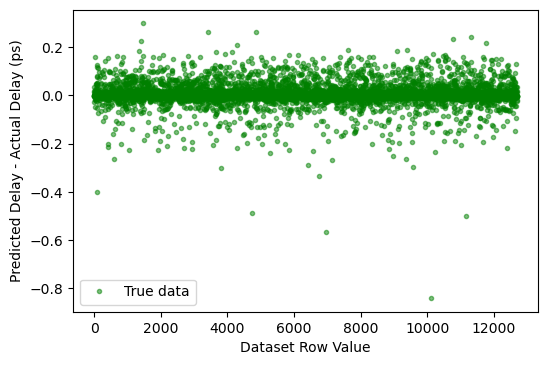

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

print ("X_Test")
print (Variable(torch.from_numpy(X_test)))
print ("Y_Test")
print (Variable(torch.from_numpy(Y_test)))
print ("Predicted Y")
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(X_test).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(X_test))).data.numpy()
    print(predicted)


print("Printing l1 weights")
print(model.l1.weight.data)
print("Weights printed")
print("Printing l2 weights")
print(model.l2.weight.data)
print("Weights printed")
print("Printing l1 weight gradient")
print(model.l1.weight.grad)
print(model.l2.weight.grad)



predicted = predicted.T
#Y_test = Y_test.detach().numpy()
print(predicted[0])
print(predicted)
print(Y_test)
print("Size of predicted[0]",np.size(predicted[0]))
print(np.all(Y_test))
accuracy = predicted[0] - Y_test

plt.clf()
lst = list(range(1,len(Y_test)+1))
plt.plot(lst, accuracy, 'g.', label='True data', alpha=0.5) # plot the predicted - actual delay values
plt.ylabel("Predicted Delay - Actual Delay (ps)")
plt.xlabel("Dataset Row Value")

# calculate accuracy for the algorithm 
accuracy = abs(predicted[0] - Y_test)
print(accuracy)
accuracy[accuracy>0.01] = -1
accuracy[accuracy>0] = 1
accuracy[accuracy<0] = 0
print(accuracy)
accuracy_elements = np.size(accuracy)
accuracy_sum = np.sum(accuracy)
print("Sum of elements in accuracy",accuracy_sum)
accuracy = accuracy_sum/accuracy_elements
print ("The final accuracy")
print(accuracy)
plt.legend(loc='best')
#plt.show()
plt.savefig('delay_prediction.png')

In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param)